In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
import matplotlib.pyplot as plt
import scienceplots

In [2]:
os.chdir("./text-empathy/")
from evaluation import pearsonr

In [3]:
def plot(x, y, y2=None, xlabel=None, ylabel=None, legend=[], save=False, filename=None):
    """Plot data points"""
    plt.style.use(['science'])
    fig, ax = plt.subplots(1,1)
    
    ax.plot(x,y)
    if y2 is not None:
        ax.plot(x, y2)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(legend)
    
    if save:
        plt.savefig(fname=filename+'.pdf', format = 'pdf', bbox_inches='tight')
        print(f"Saved as {filename}.pdf")
        
    fig.show()

In [55]:
task_1 = 'empathy'
task_2 = 'distress'

checkpoint = "microsoft/deberta-v3-base"

train_file = "./data/PREPROCESSED-essay-train.csv"
test_file = "./data/PREPROCESSED-essay-dev.csv"

# Multi-task learning

In [62]:
feature_1 = 'demographic_essay'
feature_2 = 'article'

In [63]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

def load_tokenised_data(filename, task_1, task_2, feature_to_tokenise, train, batch_size):

    #padding="longest" can be deferred to do dynamic padding
    def tokenise_fn(sentence):
        return tokeniser(sentence[feature_to_tokenise], truncation=True, max_length=512)
   
    input_data = pd.read_csv(filename, header=0, index_col=0)
    
    if train:
        chosen_data = input_data[[feature_to_tokenise, task_1, task_2]]
    else:
        chosen_data = input_data[[feature_to_tokenise]]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = [feature_to_tokenise])
    
    if train:
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task_1, "labels_1") # more meaningful
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task_2, "labels_2")
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")
           
    torchloader = torch.utils.data.DataLoader(
        tokenised_hugging_dataset, shuffle=train, batch_size=batch_size, collate_fn=data_collator
    )

    return torchloader

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [64]:
class BiEncoderTransformer(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(BiEncoderTransformer, self).__init__()
        
        self.transformer = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0)
        self.fc1 = nn.Linear(1536, 768) #768+768 = 1536 as I concatenate the sequence outputs
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 256)
        
        self.fc4_1 = nn.Linear(256, 1) # regression problem
        self.fc4_2 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(
        self,
        input_ids_f1=None,
        attention_mask_f1=None,
        input_ids_f2=None,
        attention_mask_f2=None,
        labels_1=None,
        labels_2=None
    ):
        outputs_f1 = self.transformer(
            input_ids = input_ids_f1,
            attention_mask = attention_mask_f1,
        )

        outputs_f2 = self.transformer(
            input_ids = input_ids_f2,
            attention_mask = attention_mask_f2,
        )

        # print(outputs_f1.keys()) #result: odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

        outputs_f1_last_state = outputs_f1[0]
        outputs_f2_last_state = outputs_f2[0]
       
        outputs_f1_cls = outputs_f1_last_state[:,0,:].view(-1, 768) # shape: (batch_size, 768)
        outputs_f2_cls = outputs_f2_last_state[:,0,:].view(-1, 768)

        X = torch.cat((outputs_f1_cls, outputs_f2_cls), dim=1) # shape: (batch_size, 1536)
        
        X = self.dropout(X)
        X = F.tanh(self.fc1(X))
        X = F.tanh(self.fc2(X))
        X = F.tanh(self.fc3(X))
        
        logits_1 = self.fc4_1(X)
        logits_2 = self.fc4_2(X)
        
        loss_1 = None
        if labels_1 is not None:
            loss_1 = F.mse_loss(logits_1.view(-1), labels_1.view(-1))

        loss_2 = None
        if labels_2 is not None:
            loss_2 = F.mse_loss(logits_2.view(-1), labels_2.view(-1))
        
        return (
            SequenceClassifierOutput(
                loss=loss_1,
                logits=logits_1
            ),
            SequenceClassifierOutput(
                loss=loss_2,
                logits=logits_2
            ),
        )

In [65]:
def train_test(lr=1e-5, batch_size=8, n_epochs=3, seed=1):
    torch.manual_seed(seed)
    
    model = BiEncoderTransformer()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    
    trainloader_f1 = load_tokenised_data(
        filename=train_file, task_1=task_1, task_2=task_2, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
    )
    trainloader_f2 = load_tokenised_data(
        filename=train_file, task_1=task_1, task_2=task_2, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
    )

    # evaluation data loader in train mode to access labels
    testloader_f1 = load_tokenised_data(
        filename=test_file, task_1=task_1, task_2=task_2, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
    )
    testloader_f2 = load_tokenised_data(
        filename=test_file, task_1=task_1, task_2=task_2, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
    )
    
    training_steps = n_epochs * len(trainloader_f1)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    wgt_1=1
    wgt_2=1

    train_loss = []
    val_loss = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for (batch_f1, batch_f2) in zip(trainloader_f1, trainloader_f2):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'labels_1': batch_f1['labels_1'].to(device), #batch_f2 labels should be the same
                'labels_2': batch_f1['labels_2'].to(device) #batch_f2 labels should be the same
            }
            opt.zero_grad()
            (outputs_1, outputs_2) = model(**batch)
            loss_1 = outputs_1.loss
            loss_2 = outputs_2.loss
            loss = wgt_1*loss_1 + wgt_2*loss_2
            loss.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss.item()
        train_loss.append(total_loss / len(trainloader_f1)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for (batch_f1, batch_f2) in zip(testloader_f1, testloader_f2):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'labels_1': batch_f1['labels_1'].to(device), #batch_f2 labels should be the same
                'labels_2': batch_f1['labels_2'].to(device) #batch_f2 labels should be the same
            }
            with torch.no_grad():
                (outputs_1, outputs_2) = model(**batch)

            batch_pred_1 = [item for sublist in outputs_1.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred_1)

            y_true.extend((batch_f1['labels_1'].tolist())) #batch_f2 labels should be the same

            loss_1 = outputs_1.loss.item()
            loss_2 = outputs_2.loss.item()
            loss = wgt_1*loss_1 + wgt_2*loss_2

            total_loss += loss
        
        val_loss.append(total_loss / len(testloader_f1))
        
        print("pearson_r:", pearsonr(y_true, y_pred))

    # train-test finished
    plot(
        x=list(range(1, n_epochs+1)),
        y=train_loss,
        y2=val_loss,
        xlabel='Epoch',
        ylabel='Loss',
        legend=['Training loss', 'Validation loss'],
        save=False,
        filename=None
    )

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Freezed layers: -1


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.068
pearson_r: 0.244
pearson_r: 0.466
pearson_r: 0.667
pearson_r: 0.662
pearson_r: 0.688
pearson_r: 0.69
pearson_r: 0.695
pearson_r: 0.715
pearson_r: 0.722
pearson_r: 0.733
pearson_r: 0.737
pearson_r: 0.742
pearson_r: 0.738
pearson_r: 0.741
pearson_r: 0.737
pearson_r: 0.738
pearson_r: 0.737
pearson_r: 0.737
pearson_r: 0.737


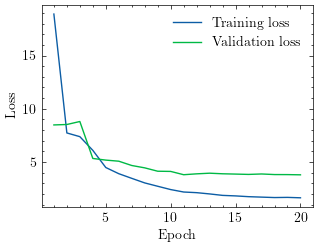

In [66]:
train_test(lr=1e-5, batch_size=8, n_epochs=20, seed=1)

# Multi-Encoder

In [79]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

def load_tokenised_data(filename, task, feature_to_tokenise, train, batch_size):

    #padding="longest" can be deferred to do dynamic padding
    def tokenise_fn(sentence):
        return tokeniser(sentence[feature_to_tokenise], truncation=True, max_length=512)
   
    input_data = pd.read_csv(filename, header=0, index_col=0)
    
    if train:
        chosen_data = input_data[[feature_to_tokenise, task]]
    else:
        chosen_data = input_data[[feature_to_tokenise]]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = [feature_to_tokenise])
    
    if train:
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task, "labels") # as huggingface requires
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")
           
    torchloader = torch.utils.data.DataLoader(
        tokenised_hugging_dataset, shuffle=train, batch_size=batch_size, collate_fn=data_collator
    )

    return torchloader

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Tri-Encoder

In [80]:
feature_1 = 'demographic'
feature_2 = 'essay'
feature_3 = 'article'

In [81]:
class TriEncoderTransformer(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(TriEncoderTransformer, self).__init__()
        
        self.transformer_f1 = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )
        
        self.transformer_f2 = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )

        self.transformer_f3 = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0)
        self.fc1 = nn.Linear(2304, 768) #768+768+768 = 2304 as I concatenate the sequence outputs
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 256)
        self.fc4 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer_f1.embeddings.parameters():
                param.requires_grad = False
            for param in self.transformer_f2.embeddings.parameters():
                param.requires_grad = False
            for param in self.transformer_f3.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer_f1.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False
                for layer in self.transformer_f2.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False
                for layer in self.transformer_f3.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(self, input_ids_f1=None, attention_mask_f1=None, input_ids_f2=None, attention_mask_f2=None, input_ids_f3=None, attention_mask_f3=None, labels=None):
        outputs_f1 = self.transformer_f1(
            input_ids = input_ids_f1,
            attention_mask = attention_mask_f1,
        )

        outputs_f2 = self.transformer_f2(
            input_ids = input_ids_f2,
            attention_mask = attention_mask_f2,
        )

        outputs_f3 = self.transformer_f3(
            input_ids = input_ids_f3,
            attention_mask = attention_mask_f3,
        )

        # print(outputs_f1.keys()) #result: odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

        outputs_f1_last_state = outputs_f1[0]
        outputs_f2_last_state = outputs_f2[0]
        outputs_f3_last_state = outputs_f3[0]
       
        outputs_f1_cls = outputs_f1_last_state[:,0,:].view(-1, 768) # shape: (batch_size, 768)
        outputs_f2_cls = outputs_f2_last_state[:,0,:].view(-1, 768)
        outputs_f3_cls = outputs_f3_last_state[:,0,:].view(-1, 768)

        X = torch.cat((outputs_f1_cls, outputs_f2_cls, outputs_f3_cls), dim=1) # shape: (batch_size, 768*3)
        
        X = self.dropout(X)
        X = F.tanh(self.fc1(X))
        X = F.tanh(self.fc2(X))
        X = F.tanh(self.fc3(X))
        logits = self.fc4(X)
        
        loss = None
        if labels is not None:
            loss = F.mse_loss(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            # hidden_states=outputs.hidden_states,
            # attentions=outputs.attentions
        )

In [87]:
def train_test(task=task_1, lr=1e-5, batch_size=8, n_epochs=3, seed=1, test=False):
    torch.manual_seed(seed)
    
    model = TriEncoderTransformer()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    
    trainloader_f1 = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
    )
    trainloader_f2 = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
    )
    trainloader_f3 = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=feature_3, train=True, batch_size=batch_size
    )

    if not test:
        # evaluation data loader in train mode to access labels
        testloader_f1 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
        )
        testloader_f2 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
        )
        testloader_f3 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_3, train=True, batch_size=batch_size
        )

    if test:
        testloader_f1 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_1, train=False, batch_size=batch_size
        )
        testloader_f2 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_2, train=False, batch_size=batch_size
        )
        testloader_f3 = load_tokenised_data(
            filename=test_file, task=task, feature_to_tokenise=feature_3, train=False, batch_size=batch_size
        )
    
    training_steps = n_epochs * len(trainloader_f1)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    train_loss = []
    val_loss = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for (batch_f1, batch_f2, batch_f3) in zip(trainloader_f1, trainloader_f2, trainloader_f3):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'input_ids_f3': batch_f3['input_ids'].to(device),
                'attention_mask_f3': batch_f3['attention_mask'].to(device),
                'labels': batch_f1['labels'].to(device) #batch_f2 labels should be the same
            }
            opt.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss.item()
        train_loss.append(total_loss / len(trainloader_f1)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for (batch_f1, batch_f2, batch_f3) in zip(testloader_f1, testloader_f2, testloader_f3):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'input_ids_f3': batch_f3['input_ids'].to(device),
                'attention_mask_f3': batch_f3['attention_mask'].to(device)
            }
            with torch.no_grad():
                outputs = model(**batch)

            batch_pred = [item for sublist in outputs.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)

            if not test:
                y_true.extend((batch_f1['labels'].tolist())) #batch_f2 labels should be the same
                total_loss += outputs.loss.item()
        
        if not test:
            val_loss.append(total_loss / len(testloader_f1))
            print("pearson_r:", pearsonr(y_true, y_pred))
        
    #save the last epoch's prediction 
    if test:
        y_pred_df = pd.DataFrame({task: y_pred})
        filename = "./tmp/predictions_" + task + ".tsv"
        y_pred_df.to_csv(filename, sep='\t', header=False, index=False)
    
    if not test:
        # train-test finished
        plot(
            x=list(range(1, n_epochs+1)),
            y=train_loss,
            y2=val_loss,
            xlabel='Epoch',
            ylabel='Loss',
            legend=['Training loss', 'Validation loss'],
            save=False,
            filename=None
        )

In [83]:
train_file = "./data/PREPROCESSED-essay-train-dev.csv"
test_file = "./data/PREPROCESSED-test.csv"

In [88]:
train_test(task=task_1, lr=1e-5, batch_size=8, n_epochs=10, seed=1, test=True)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the m

Freezed layers: -1


Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [89]:
train_test(task=task_2, lr=1e-5, batch_size=8, n_epochs=10, seed=1, test=True)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the m

Freezed layers: -1


Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/987 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [90]:
predictions_1 = pd.read_csv("./tmp/predictions_" + task_1 + ".tsv", sep='\t', header=None)
predictions_2 = pd.read_csv("./tmp/predictions_" + task_2 + ".tsv", sep='\t', header=None)
predictions = pd.concat([predictions_1, predictions_2], axis=1)
predictions.to_csv("./tmp/predictions_EMP.tsv", sep='\t', header=False, index=False)

## Bi-Encoder

In [57]:
feature_1 = 'demographic_essay'
feature_2 = 'article'

In [59]:
class BiEncoderTransformer(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(BiEncoderTransformer, self).__init__()
        
        self.transformer_f1 = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )
        
        self.transformer_f2 = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0)
        self.fc1 = nn.Linear(1536, 768) #768+768 = 1536 as I concatenate the sequence outputs
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 256)
        self.fc4 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer_f1.embeddings.parameters():
                param.requires_grad = False
            for param in self.transformer_f2.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer_f1.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False
                for layer in self.transformer_f2.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(self, input_ids_f1=None, attention_mask_f1=None, input_ids_f2=None, attention_mask_f2=None, labels=None):
        outputs_f1 = self.transformer_f1(
            input_ids = input_ids_f1,
            attention_mask = attention_mask_f1,
        )

        outputs_f2 = self.transformer_f1(
            input_ids = input_ids_f2,
            attention_mask = attention_mask_f2,
        )

        # print(outputs_f1.keys()) #result: odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

        outputs_f1_last_state = outputs_f1[0]
        outputs_f2_last_state = outputs_f2[0]
       
        outputs_f1_cls = outputs_f1_last_state[:,0,:].view(-1, 768) # shape: (batch_size, 768)
        outputs_f2_cls = outputs_f2_last_state[:,0,:].view(-1, 768)

        X = torch.cat((outputs_f1_cls, outputs_f2_cls), dim=1) # shape: (batch_size, 1536)
        
        X = self.dropout(X)
        X = F.tanh(self.fc1(X))
        X = F.tanh(self.fc2(X))
        X = F.tanh(self.fc3(X))
        logits = self.fc4(X)
        
        loss = None
        if labels is not None:
            loss = F.mse_loss(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            # hidden_states=outputs.hidden_states,
            # attentions=outputs.attentions
        )

In [60]:
def train_test(task=task_1, lr=1e-5, batch_size=8, n_epochs=3, seed=1):
    torch.manual_seed(seed)
    
    model = BiEncoderTransformer()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    
    trainloader_f1 = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
    )
    trainloader_f2 = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
    )

    # evaluation data loader in train mode to access labels
    testloader_f1 = load_tokenised_data(
        filename=test_file, task=task, feature_to_tokenise=feature_1, train=True, batch_size=batch_size
    )
    testloader_f2 = load_tokenised_data(
        filename=test_file, task=task, feature_to_tokenise=feature_2, train=True, batch_size=batch_size
    )
    
    training_steps = n_epochs * len(trainloader_f1)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    train_loss = []
    val_loss = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for (batch_f1, batch_f2) in zip(trainloader_f1, trainloader_f2):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'labels': batch_f1['labels'].to(device) #batch_f2 labels should be the same
            }
            opt.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss.item()
        train_loss.append(total_loss / len(trainloader_f1)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for (batch_f1, batch_f2) in zip(testloader_f1, testloader_f2):
            batch = {
                'input_ids_f1': batch_f1['input_ids'].to(device),
                'attention_mask_f1': batch_f1['attention_mask'].to(device),
                'input_ids_f2': batch_f2['input_ids'].to(device),
                'attention_mask_f2': batch_f2['attention_mask'].to(device),
                'labels': batch_f1['labels'].to(device) #batch_f2 labels should be the same
            }
            with torch.no_grad():
                outputs = model(**batch)

            batch_pred = [item for sublist in outputs.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)

            y_true.extend((batch_f1['labels'].tolist())) #batch_f2 labels should be the same
            total_loss += outputs.loss.item()
        
        val_loss.append(total_loss / len(testloader_f1))
        
        print("pearson_r:", pearsonr(y_true, y_pred))

    # train-test finished
    plot(
        x=list(range(1, n_epochs+1)),
        y=train_loss,
        y2=val_loss,
        xlabel='Epoch',
        ylabel='Loss',
        legend=['Training loss', 'Validation loss'],
        save=False,
        filename=None
    )

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the m

Freezed layers: -1


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.033
pearson_r: 0.557
pearson_r: 0.498
pearson_r: 0.599
pearson_r: 0.668
pearson_r: 0.669
pearson_r: 0.69
pearson_r: 0.709
pearson_r: 0.714
pearson_r: 0.734
pearson_r: 0.727
pearson_r: 0.744
pearson_r: 0.735
pearson_r: 0.732
pearson_r: 0.737
pearson_r: 0.742
pearson_r: 0.743
pearson_r: 0.738
pearson_r: 0.739
pearson_r: 0.737


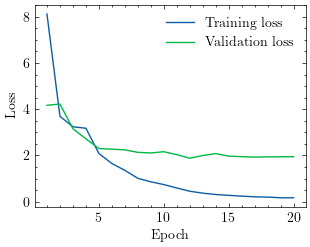

In [61]:
train_test(task=task_1, lr=1e-5, batch_size=8, n_epochs=20, seed=1)

# Combined two sequences by SEP

In [5]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

#padding="longest" can be deferred to do dynamic padding
def tokenise(sentence):
    return tokeniser(sentence[feature_1], sentence[feature_2], truncation=True, max_length=512)

def load_tokenised_data(filename, task, tokenise_fn, train):
   
    input_data = pd.read_csv(filename, header=0, index_col=0)
    
    if train:
        chosen_data = input_data[[feature_1, feature_2, task]]
    else:
        chosen_data = input_data[[feature_1, feature_2]]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = [feature_1, feature_2])
    
    if train:
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task, "labels") # as huggingface requires
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")

    return tokenised_hugging_dataset

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
class CustomRegressor(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(CustomRegressor, self).__init__()

        self.transformer_last_hidden_size = 768
        self.transformer = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True,
                num_labels=self.transformer_last_hidden_size
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0)
        self.fc1 = nn.Linear(self.transformer_last_hidden_size, 256)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer.deberta.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer.deberta.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        # print(outputs.keys())
        # will return ['logits', 'hidden_states', 'attentions']

        x = self.dropout(outputs.logits) # output.logits aka pooled output from [CLS] token beacuse of AutoModelForSequenceClassification
        # x = F.tanh(self.fc1(x))
        x = self.fc1(x)
        # x = F.relu(self.fc2(x))
        logits = self.fc3(x)
                
        loss = None
        if labels is not None:
            loss = F.mse_loss(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [9]:
def train_test(task=task, lr=1e-5, batch_size=8, n_epochs=3, seed=1):
    torch.manual_seed(seed)
    
    model = CustomRegressor()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    print(model)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    
    trainset = load_tokenised_data(
        filename=train_file, task=task, tokenise_fn=tokenise, train=True
    )           
    trainloader = torch.utils.data.DataLoader(
        trainset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    
    # evaluation data loader in train mode to access labels
    testset = load_tokenised_data(
        filename=test_file, task=task, tokenise_fn=tokenise, train=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, shuffle=False, batch_size=batch_size, collate_fn=data_collator
    )

    training_steps = n_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    train_loss = []
    val_loss = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for batch in trainloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            opt.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss.item()

        train_loss.append(total_loss / len(trainloader)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for batch in testloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            batch_pred = [item for sublist in outputs.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)
            y_true.extend((batch['labels'].tolist()))
            total_loss += outputs.loss.item()
        
        val_loss.append(total_loss / len(testloader))

        # print(y_pred)
        print("pearson_r:", pearsonr(y_true, y_pred))

    # train-test finished
    plot(
        x=list(range(1, n_epochs+1)),
        y=train_loss,
        y2=val_loss,
        xlabel='Epoch',
        ylabel='Loss',
        legend=['Training loss', 'Validation loss'],
        save=False,
        filename=None
    )

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Freezed layers: -1
CustomRegressor(
  (transformer): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_features

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.261
pearson_r: 0.563
pearson_r: 0.641
pearson_r: 0.729
pearson_r: 0.725
pearson_r: 0.763
pearson_r: 0.774
pearson_r: 0.777
pearson_r: 0.773
pearson_r: 0.772


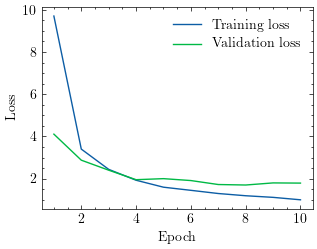

In [10]:
train_test(task=task, lr=1e-5, batch_size=8, n_epochs=10, seed=1)

# Correlation

In [41]:
data = pd.read_csv(train_file, header=0, index_col=0)
pearsonr(data['empathy'], data['distress'])

0.644

In [40]:
data = pd.read_csv(test_file, header=0, index_col=0)
pearsonr(data['empathy'], data['distress'])

0.594

# Extra

In [125]:
for i in range(-1, 12):
    print("n_freeze:", i)
    train_test(task=task, lr=1e-5, batch_size=8, n_epochs=5, n_freeze=i, seed=1)
    print("\n")

n_freeze: -1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.201
pearson_r: 0.568
pearson_r: 0.625
pearson_r: 0.716
pearson_r: 0.733


n_freeze: 0


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.2
pearson_r: 0.575
pearson_r: 0.609
pearson_r: 0.682
pearson_r: 0.714


n_freeze: 1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.23
pearson_r: 0.499
pearson_r: 0.602
pearson_r: 0.696
pearson_r: 0.711


n_freeze: 2


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.271
pearson_r: 0.447
pearson_r: 0.604
pearson_r: 0.693
pearson_r: 0.716


n_freeze: 3


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.261
pearson_r: 0.316
pearson_r: 0.441
pearson_r: 0.525
pearson_r: 0.539


n_freeze: 4


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.242
pearson_r: 0.216
pearson_r: 0.436
pearson_r: 0.515
pearson_r: 0.518


n_freeze: 5


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.166
pearson_r: 0.257
pearson_r: 0.457
pearson_r: 0.495
pearson_r: 0.499


n_freeze: 6


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.182
pearson_r: 0.318
pearson_r: 0.439
pearson_r: 0.507
pearson_r: 0.516


n_freeze: 7


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.14
pearson_r: 0.294
pearson_r: 0.425
pearson_r: 0.503
pearson_r: 0.516


n_freeze: 8


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.087
pearson_r: 0.382
pearson_r: 0.482
pearson_r: 0.502
pearson_r: 0.511


n_freeze: 9


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.239
pearson_r: 0.432
pearson_r: 0.473
pearson_r: 0.493
pearson_r: 0.501


n_freeze: 10


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.162
pearson_r: 0.312
pearson_r: 0.385
pearson_r: 0.424
pearson_r: 0.432


n_freeze: 11


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.139
pearson_r: 0.166
pearson_r: 0.189
pearson_r: 0.2
pearson_r: 0.205




## AutoModel vs AutoModelForSequenceClassification

In [ ]:
from torchinfo import summary

In [142]:
temp = CustomTransformer()
print(temp)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomTransformer(
  (transformer): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      

In [143]:
temp2 = CustomTransformerSequenceClassificaiton()
print(temp2)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

CustomTransformerSequenceClassificaiton(
  (transformer): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_fea

In [144]:
summary(temp)

Layer (type:depth-idx)                                            Param #
CustomTransformer                                                 --
├─DebertaV2Model: 1-1                                             --
│    └─DebertaV2Embeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                        98,380,800
│    │    └─LayerNorm: 3-2                                        1,536
│    │    └─StableDropout: 3-3                                    --
│    └─DebertaV2Encoder: 2-2                                      --
│    │    └─ModuleList: 3-4                                       85,054,464
│    │    └─Embedding: 3-5                                        393,216
│    │    └─LayerNorm: 3-6                                        1,536
├─Sequential: 1-2                                                 --
│    └─Linear: 2-3                                                590,592
│    └─Tanh: 2-4                                                  

In [145]:
summary(temp2)

Layer (type:depth-idx)                                                 Param #
CustomTransformerSequenceClassificaiton                                --
├─DebertaV2ForSequenceClassification: 1-1                              --
│    └─DebertaV2Model: 2-1                                             --
│    │    └─DebertaV2Embeddings: 3-1                                   98,382,336
│    │    └─DebertaV2Encoder: 3-2                                      85,449,216
│    └─ContextPooler: 2-2                                              --
│    │    └─Linear: 3-3                                                590,592
│    │    └─StableDropout: 3-4                                         --
│    └─Linear: 2-3                                                     590,592
│    └─StableDropout: 2-4                                              --
├─Dropout: 1-2                                                         --
├─Linear: 1-3                                                          196,864
├─

## Earlier w/o *ForSequenceClassfication

In [15]:
class CustomTransformer(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", num_labels=1):
        super(CustomTransformer, self).__init__()
        
        self.num_labels=num_labels
        
        self.transformer = AutoModel.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True
            ),
            ignore_mismatched_sizes=True
        )
        
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 768)
        self.linear2 = nn.Linear(768, 768)
        self.linear3 = nn.Linear(768, 256)
        self.linearn = nn.Linear(256, num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        
        sequence_output = self.dropout(outputs[0]) #last_hidden_state
        linear1_output = self.linear1(sequence_output[:,0,:].view(-1, 768)) #first token's embedding
        linear2_output = self.linear2(F.tanh(linear1_output))
        linear3_output = self.linear3(self.dropout(linear2_output))
        logits = self.linearn(linear3_output)
        
        loss = None
        if labels is not None:
            criterion = nn.MSELoss()
            loss = criterion(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [16]:
def train_test(task=task, lr=1e-5, batch_size=8, n_epochs=3, n_freeze=0, seed=1):
    torch.manual_seed(seed)
    
    model = CustomTransformer()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Freezing layers
    if n_freeze:
        # freeze the embedding layer when n_freeze = -1)
        for param in model.transformer.embeddings.parameters():
            param.requires_grad = False

        # freeze other layers as per n_freeze
        if n_freeze != -1:
            for layer in model.transformer.encoder.layer[:n_freeze]:
                for param in layer.parameters():
                    param.requires_grad = False

    # print("Unfreezed layers:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)
    # print("\n")

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    
    trainset = load_tokenised_data(
        filename=train_file, task=task, tokenise_fn=tokenise, train=True
    )
           
    trainloader = torch.utils.data.DataLoader(
        trainset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    
    # evaluation data loader in train mode to access labels
    testset = load_tokenised_data(
        filename=test_file, task=task, tokenise_fn=tokenise, train=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, shuffle=False, batch_size=batch_size, collate_fn=data_collator
    )

    training_steps = n_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )
    
    for epoch in range(0, n_epochs):
        model.train()
        for batch in trainloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            
            opt.step()
            lr_scheduler.step()
            opt.zero_grad()

        model.eval()
        y_pred = []
        y_true = []
        for batch in testloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            batch_pred = [item for sublist in outputs.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)

            y_true.extend((batch['labels'].tolist()))

        print("pearson_r:", pearsonr(y_true, y_pred))

In [17]:
for i in range(-1, 12):
    print("n_freeze:", i)
    train_test(task=task, lr=1e-5, batch_size=8, n_epochs=5, n_freeze=i, seed=1)
    print("\n")

n_freeze: -1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.109
pearson_r: 0.296
pearson_r: 0.519
pearson_r: 0.572
pearson_r: 0.614


n_freeze: 0


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.11
pearson_r: 0.296
pearson_r: 0.531
pearson_r: 0.574
pearson_r: 0.614


n_freeze: 1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.102
pearson_r: 0.22
pearson_r: 0.044
pearson_r: 0.458
pearson_r: 0.515


n_freeze: 2


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.082
pearson_r: 0.255
pearson_r: 0.175
pearson_r: 0.471
pearson_r: 0.518


n_freeze: 3


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.096
pearson_r: 0.211
pearson_r: 0.413
pearson_r: 0.477
pearson_r: 0.512


n_freeze: 4


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.089
pearson_r: 0.244
pearson_r: 0.478
pearson_r: 0.489
pearson_r: 0.554


n_freeze: 5


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.089
pearson_r: 0.329
pearson_r: 0.476
pearson_r: 0.559
pearson_r: 0.585


n_freeze: 6


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.109
pearson_r: 0.421
pearson_r: 0.488
pearson_r: 0.553
pearson_r: 0.562


n_freeze: 7


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.003
pearson_r: 0.412
pearson_r: 0.487
pearson_r: 0.55
pearson_r: 0.564


n_freeze: 8


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.117
pearson_r: 0.446
pearson_r: 0.513
pearson_r: 0.554
pearson_r: 0.561


n_freeze: 9


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.197
pearson_r: 0.448
pearson_r: 0.529
pearson_r: 0.566
pearson_r: 0.574


n_freeze: 10


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.06
pearson_r: 0.256
pearson_r: 0.355
pearson_r: 0.401
pearson_r: 0.413


n_freeze: 11


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.155
pearson_r: 0.177
pearson_r: 0.203
pearson_r: 0.207
pearson_r: 0.215




In [70]:
## Earlier without pooling effort
for i in range(-1, 12):
    print("n_freeze:", i)
    train_test(task=task, lr=1e-5, batch_size=8, n_epochs=5, n_freeze=i, seed=1)
    print("\n")

n_freeze: -1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.243
pearson_r: 0.449
pearson_r: 0.51
pearson_r: 0.553
pearson_r: 0.57


n_freeze: 0


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.246
pearson_r: 0.454
pearson_r: 0.51
pearson_r: 0.558
pearson_r: 0.575


n_freeze: 1


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.405
pearson_r: 0.48
pearson_r: 0.505
pearson_r: 0.57
pearson_r: 0.585


n_freeze: 2


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.398
pearson_r: 0.455
pearson_r: 0.551
pearson_r: 0.612
pearson_r: 0.625


n_freeze: 3


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.258
pearson_r: 0.415
pearson_r: 0.531
pearson_r: 0.589
pearson_r: 0.592


n_freeze: 4


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.261
pearson_r: 0.446
pearson_r: 0.494
pearson_r: 0.541
pearson_r: 0.582


n_freeze: 5


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.212
pearson_r: 0.423
pearson_r: 0.45
pearson_r: 0.493
pearson_r: 0.524


n_freeze: 6


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.307
pearson_r: 0.445
pearson_r: 0.477
pearson_r: 0.533
pearson_r: 0.554


n_freeze: 7


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.22
pearson_r: 0.41
pearson_r: 0.459
pearson_r: 0.475
pearson_r: 0.485


n_freeze: 8


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.195
pearson_r: 0.369
pearson_r: 0.436
pearson_r: 0.473
pearson_r: 0.483


n_freeze: 9


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.062
pearson_r: 0.36
pearson_r: 0.458
pearson_r: 0.494
pearson_r: 0.504


n_freeze: 10


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.127
pearson_r: 0.268
pearson_r: 0.341
pearson_r: 0.383
pearson_r: 0.394


n_freeze: 11


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.148
pearson_r: 0.134
pearson_r: 0.158
pearson_r: 0.174
pearson_r: 0.179


